# Utils

In [22]:
import past
import os
import scanpy as sc
import warnings
import torch
import numpy as np
import pandas as pd

In [23]:
warnings.filterwarnings("ignore")
sc.set_figure_params(dpi=80, figsize=(4,4), facecolor="white")
os.environ["R_HOME"] = "/home/lizhen/miniconda3/envs/scTECH-R/lib/R"
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [24]:
## DLPFC DATASET
os.chdir("/home/lizhen/data/STdata/DLPFC")
DLPFC_data = sc.read_h5ad(filename = "Human_DLPFC_Visium_anndata_plus_img.h5ad")
DLPFC_data.var_names_make_unique()

DLPFC_data = DLPFC_data[np.array(DLPFC_data.obs["ManualAnnotation"], dtype=str) != "nan", :]
DLPFC_data.obs["ManualAnnotation"] = DLPFC_data.obs["ManualAnnotation"].astype("category")
sdata = DLPFC_data[DLPFC_data.obs["sample_id"] == "151507", :]
sdata

Trying to set attribute `.obs` of view, copying.


View of AnnData object with n_obs × n_vars = 4221 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'sample_id', 'ManualAnnotation'
    var: 'source', 'type', 'gene_id', 'gene_version', 'gene_name'
    uns: 'spatial'
    obsm: 'spatial'

In [4]:
past.setup_seed(666)

In [5]:
sdata = past.preprocess(sdata, min_cells=3, is_filter_MT=True, n_tops=3000, gene_method="gearyc")

Trying to set attribute `.var` of view, copying.


In [6]:
PAST = past.PAST(d_in=sdata.shape[1], d_lat=50, k_neighbors=6, dropout=0.1).to(device)

In [7]:
PAST.model_train(sdata, epochs=50, lr=1e-3, batchsize=6400, device=device)

This dataset is small enough to train without Ripplewalk_sampler
Epoch:1 Time:5.12s Loss: 10.333552
Epoch:2 Time:1.47s Loss: 5.293160
Epoch:3 Time:1.49s Loss: 4.258145
Epoch:4 Time:1.47s Loss: 3.576831
Epoch:5 Time:1.49s Loss: 3.029965
Epoch:6 Time:1.48s Loss: 2.537145
Epoch:7 Time:1.50s Loss: 2.100833
Epoch:8 Time:1.47s Loss: 1.688188
Epoch:9 Time:1.48s Loss: 1.329934
Epoch:10 Time:1.48s Loss: 1.015258
Epoch:11 Time:1.47s Loss: 0.735684
Epoch:12 Time:1.47s Loss: 0.554345
Epoch:13 Time:1.47s Loss: 0.422745
Epoch:14 Time:1.47s Loss: 0.343069
Epoch:15 Time:1.49s Loss: 0.288764
Epoch:16 Time:1.48s Loss: 0.252488
Epoch:17 Time:1.48s Loss: 0.229762
Epoch:18 Time:1.47s Loss: 0.211366
Epoch:19 Time:1.50s Loss: 0.198916
Epoch:20 Time:1.51s Loss: 0.188105
Model Converge


In [8]:
sdata = PAST.output(sdata)

In [9]:
key = "ManualAnnotation"

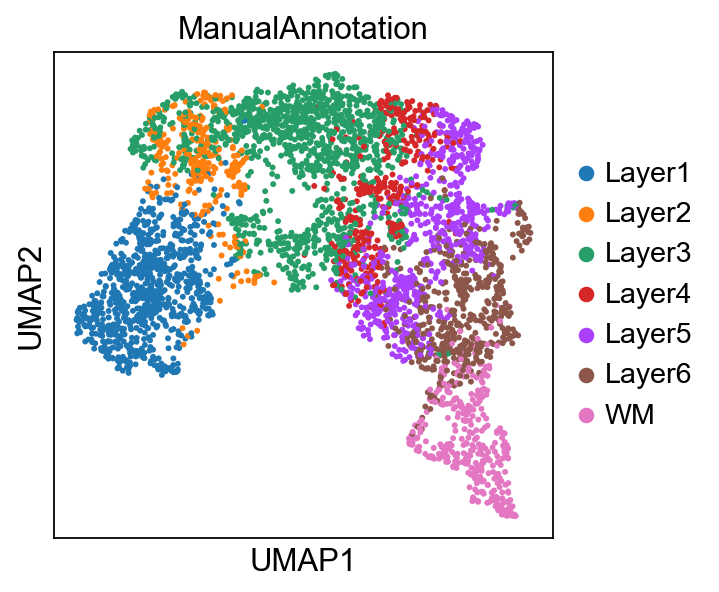

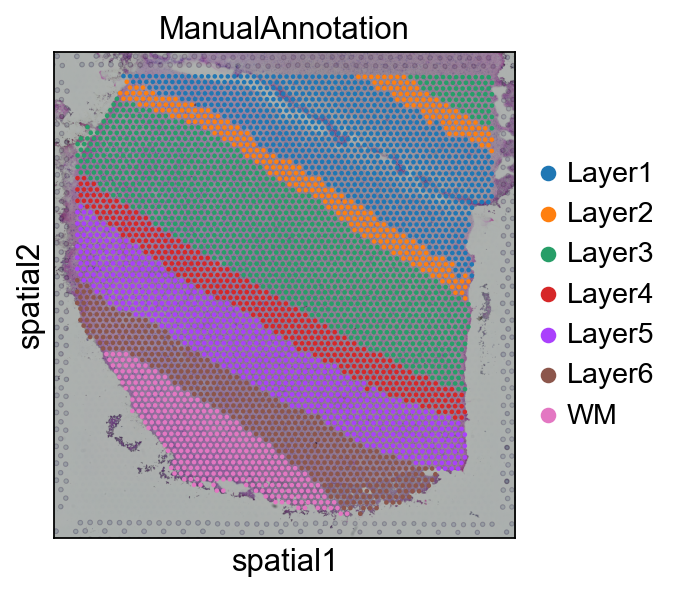

In [11]:
past.visualize(sdata, keys=["ManualAnnotation"], use_rep="embedding", library_id="151507", plot_spatial=True)

In [12]:
sdata = past.mclust_R(sdata, num_cluster=sdata.obs[key].nunique(), refine=True, num_nbs=6, used_obsm='embedding')
sdata = past.default_louvain(sdata, refine=True, num_nbs=6, use_rep="embedding")
sdata = past.default_leiden(sdata, refine=True, num_nbs=6, use_rep="embedding")

R[write to console]:     __  ___________    __  _____________
   /  |/  / ____/ /   / / / / ___/_  __/
  / /|_/ / /   / /   / / / /\__ \ / /   
 / /  / / /___/ /___/ /_/ /___/ // /    
/_/  /_/\____/_____/\____//____//_/    version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
Finish refining
Finish refining
Finish refining


In [19]:
print("Mclust metrics:", end="\t\t")
ari, ami, homo, nmi = past.cluster_metrics(sdata, key, "mclust")
print("Dlouvain metrics:", end="\t")
ari, ami, homo, nmi = past.cluster_metrics(sdata, key, "Dlouvain")

Mclust metrics:		ARI: 0.538, AMI: 0.678, Homo: 0.661, NMI: 0.678
Dlouvain metrics:	ARI: 0.307, AMI: 0.536, Homo: 0.641, NMI: 0.538
